In [5]:
import csv

'Load the raw data'
def load_samples():
    samples = []
    with open('./data/driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)
        for sample in reader:
            if float(sample[3])!=0:
                samples.append(sample)
    return samples

samples = load_samples()
print(len(samples))


3675


3675 3675ample: 3674 of 3675


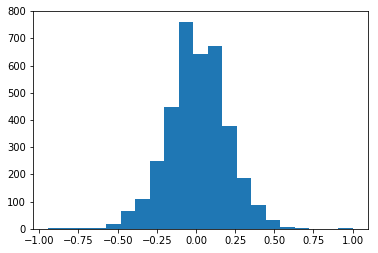

Wall time: 6.87 s


In [13]:
%%time
import cv2
import matplotlib.pyplot as plt

'Function to extract images and steering angles from raw data'
def load_images(samples):
    images = []
    steering_angles = []
    num_samples = len(samples)
    
    for i, sample in enumerate(samples):
        print('Reading Sample: '+str(i)+' of '+str(num_samples), end='\r')
        for j in range(1):
            source_path = sample[j]
            filename = source_path.split('/')[-1]
            image_path = './data/IMG/' + filename
            image = cv2.imread(image_path)
            images.append((cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

        steering_angle_center = float(sample[3])
        steering_angles.append(steering_angle_center)
        #steering_angles.append(steering_angle_center + 0.2)
        #steering_angles.append(steering_angle_center - 0.2)    
    return images, steering_angles

images, steering_angles = load_images(samples)
print(len(images), len(steering_angles))

plt.hist(steering_angles, 21)
plt.show()


In [4]:
%%time
import numpy as np

'Function to augment the images and steering angles'
def augment_data(images, steering_angles):
    augmented_images = []
    augmented_steering_angles = []
    for image, steering_angle in zip(images, steering_angles):
        augmented_images.append(image)
        augmented_steering_angles.append(steering_angle)
        flipped_image = cv2.flip(image, 1)
        flipped_steering_angle = steering_angle * -1.0
        augmented_images.append(flipped_image)
        augmented_steering_angles.append(flipped_steering_angle)
    return augmented_images, augmented_steering_angles

augmented_images, augmented_steering_angles = augment_data(images, steering_angles)
print(len(augmented_images), len(augmented_steering_angles))
x_train = np.array(augmented_images)
y_train = np.array(augmented_steering_angles)
print (x_train.shape)
print (y_train.shape)


48216 48216
(48216, 160, 320, 3)
(48216,)
Wall time: 10.8 s


In [8]:
import sklearn
from sklearn.model_selection import train_test_split

'Generator function to process data in batches'
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while True:                                                # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images, steering_angles = load_images(batch_samples)
            # augmented_images, augmented_steering_angles = augment_data(images, steering_angles)

            X_train = np.array(augmented_images)
            y_train = np.array(augmented_steering_angles)
            yield sklearn.utils.shuffle(x_train, y_train)

In [10]:
import matplotlib.pyplot as plt
import os

'Plot the training and validation loss for each epoch'
def plot_history(history_object, save_path, title):
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('Model Mean Squared Error Loss')
    plt.ylabel('MSE Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training set', 'Validation set'], loc='upper right')
    plt.savefig(os.path.join(save_path + title + '.png'))
    plt.show()

In [14]:
import keras
from keras.models import Sequential, Model
from keras.layers import Lambda, Flatten, Dense, Activation, Dropout
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D

'Simple Regression Model'
def simple_model():
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((70, 25), (0, 0))))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

'LeNet Model'
def lenet_model():
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((70, 25), (0, 0))))
    model.add(Convolution2D(filters=6, kernel_size=(5, 5), strides=(2, 2), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(16, (5, 5), strides=(2, 2), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

'NVIDIA End-to-End Model'
def nvidia_model():
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160, 320, 3)))
    model.add(Cropping2D(cropping=((50, 20), (0, 0))))
    model.add(Convolution2D(filters=24, kernel_size=(5, 5), strides=(2, 2), activation='relu'))     # Layer 1
    model.add(Convolution2D(filters=36, kernel_size=(5, 5), strides=(2, 2), activation='relu'))     # Layer 2
    model.add(Convolution2D(filters=48, kernel_size=(5, 5), strides=(2, 2), activation='relu'))     # Layer 3
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))     # Layer 4
    model.add(Convolution2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))     # Layer 4
    model.add(Flatten())                                                                            # Layer 5
    model.add(Dense(1164, activation='relu'))                                                       # Layer 6
    model.add(Dense(100, activation='relu'))                                                        # Layer 7
    model.add(Dense(10, activation='relu'))                                                         # Layer 8
    model.add(Dense(1))                                                                             # Layer 9
    model.compile(optimizer='adam', loss='mse')
    return model

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\envs\carnd\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "C:\ProgramData\Miniconda3\envs\carnd\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "C:\ProgramData\Miniconda3\envs\carnd\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "C:\ProgramData\Miniconda3\envs\carnd\lib\imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "C:\ProgramData\Miniconda3\envs\carnd\lib\imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: DLL load failed: The specified module could not be found.


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
# compile and train the model using the generator function
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

print(len(train_samples)/32, len(validation_samples)/32)

In [ ]:
model = nvidia_model()
history_object = model.fit_generator(train_generator, 
                               steps_per_epoch=len(train_samples)/32, 
                               validation_data=validation_generator, 
                               validation_steps=len(validation_samples)/32, 
                               epochs=50, 
                               verbose=1)
plot_history(history_object, './images/', 'model')
model.save('model.h5')
